In [49]:
# Base Libraries
import pandas as pd
import numpy as np
from functools import partial
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Classifier
from sklearn.svm import SVC
# Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
1
from sklearn.model_selection import (
train_test_split,
TimeSeriesSplit
)
# Metrics
from sklearn.metrics import (
accuracy_score,
classification_report,
RocCurveDisplay,
ConfusionMatrixDisplay,
log_loss
)
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from collections import Counter
from sklearn.inspection import permutation_importance

In [2]:
#load nifty index data
df = pd.read_csv('https://raw.githubusercontent.com/kannansingaravelu/datasets/main/niftyindex.csv',
                 index_col=0,
                 dayfirst=True)
df

,Open,High,Low,Close,Volume
02/01/2012,4640.20,4645.95,4588.05,4636.75,108461000
03/01/2012,4675.80,4773.10,4675.80,4765.30,146621008
04/01/2012,4774.95,4782.85,4728.85,4749.65,165939008
05/01/2012,4749.00,4779.80,4730.15,4749.95,177863008
06/01/2012,4724.15,4794.90,4686.85,4754.10,176057008
...,...,...,...,...,...
26/12/2022,17830.40,18084.10,17774.25,18014.60,176652336
27/12/2022,18089.80,18149.25,17967.45,18132.30,214257088
28/12/2022,18084.75,18173.10,18068.35,18122.50,193873168
29/12/2022,18045.70,18229.70,17992.80,18191.00,281052832


In [3]:
# Get Info
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2719 entries, 02/01/2012 to 30/12/2022
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    2719 non-null   float64
 1   High    2719 non-null   float64
 2   Low     2719 non-null   float64
 3   Close   2719 non-null   float64
 4   Volume  2719 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 127.5+ KB


In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,2719.0,1.012490e+04,3.709607e+03,4640.20,7.637000e+03,9.376950e+03,1.170085e+04,1.887195e+04
High,2719.0,1.017529e+04,3.725527e+03,4645.95,7.681000e+03,9.431900e+03,1.175512e+04,1.888760e+04
Low,2719.0,1.005747e+04,3.685305e+03,4588.05,7.581650e+03,9.301350e+03,1.163133e+04,1.877820e+04
Close,2719.0,1.011757e+04,3.706945e+03,4636.75,7.623800e+03,9.351850e+03,1.168400e+04,1.881250e+04
Volume,2719.0,2.892221e+08,1.952768e+08,2826000.00,1.591780e+08,2.194961e+08,3.409088e+08,1.810971e+09


In [5]:
df.isnull().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [6]:
# create features
def create_features(frame):
    df = frame.copy()
    multiplier = 2
    # features
    df['OC'] = df['Close'] / df['Open'] - 1
    df['HC'] = df['High'] / df['Low'] - 1
    df['GAP'] = df['Open'] / df['Close'].shift(1) - 1
    df['RET'] = np.log(df['Close'] / df['Close'].shift(1))

    for i in [7, 14, 28]:
        df['PCHG' + str(i)] = df['Close'].pct_change(i)
        df['VCHG' + str(i)] = df['Volume'].pct_change(i)
        df['RET' + str(i)] = df['RET'].rolling(i).sum()
        df['MA' + str(i)] = df['Close'] / df['Close'].rolling(i).mean()
        df['VMA' + str(i)] = df['Volume'] / df['Volume'].rolling(i).mean()
        df['OC'+ str(i)] = df['OC'].rolling(i).mean()
        df['HC'+ str(i)] = df['HC'].rolling(i).mean()
        df['GAP'+ str(i)] = df['GAP'].rolling(i).mean()
        df['STD'+ str(i)] = df['RET'].rolling(i).std()
        df['UB'+str(i)] = df['Close'].rolling(i).mean() + df['Close'].rolling(i).std() * multiplier
        df['LB'+str(i)] = df['Close'].rolling(i).mean() - df['Close'].rolling(i).std() * multiplier

    # fill NaN values with the average of the column
    for col in df.columns:
        df[col].fillna(df[col].mean(), inplace=True)

    # drop NaN values
    df['Label'] = df['Close'].shift(-1)
    df.drop(['Open', 'High', 'Low', 'Volume'], axis=1, inplace=True)
    df.dropna(inplace=True)
    return df

In [7]:
# features
df1 = create_features(df)
display(df1.shape)

# verify the output
df1.head(2)

(2718, 39)

,Close,OC,HC,GAP,RET,PCHG7,VCHG7,RET7,MA7,VMA7,...,RET28,MA28,VMA28,OC28,HC28,GAP28,STD28,UB28,LB28,Label
02/01/2012,4636.75,-0.000744,0.012620,0.001205,0.000501,0.003866,0.102204,0.003449,1.001524,1.002731,...,0.013517,1.006646,1.004614,-0.000663,0.011884,0.001208,0.009541,10517.850419,9687.522536,4765.30
03/01/2012,4765.30,0.019141,0.020809,0.008422,0.027347,0.003866,0.102204,0.003449,1.001524,1.002731,...,0.013517,1.006646,1.004614,-0.000663,0.011884,0.001208,0.009541,10517.850419,9687.522536,4749.65


In [8]:
# label
y = np.array(df1['Label'])
y

array([ 4765.3 ,  4749.65,  4749.95, ..., 18122.5 , 18191.  , 18105.3 ])

In [9]:
# drop label from dataframe
df1.drop('Label', axis=1, inplace=True)

Text(0.5, 1.0, 'Features Set Correlations')

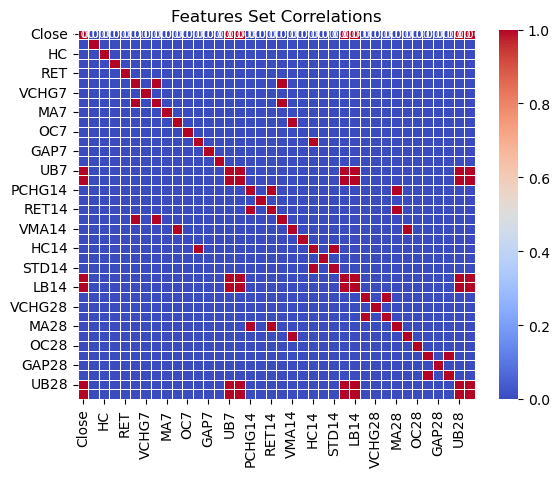

In [10]:
# remove features that are highly correlated
sns.heatmap(df1.corr()>0.9,
            annot=True,
            annot_kws={"size": 8},
            fmt=".2f",
            linewidth=.5,
            cmap="coolwarm",
            cbar=True); #cmap="crest", virids, magma

plt.title('Features Set Correlations')

In [11]:
# remove the first feature that is correlated with any other feature
def correlated_features(data, threshold=0.9):
    col_corr = set()
    corr_matrix = df1.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    return col_corr

In [12]:
#total correlated features
drop_correlated_features = correlated_features(df1)

# drop the highly correlated features
X = df1.drop(drop_correlated_features, axis=1)

# record feature names
feature_names = X.columns

In [13]:
# display the new features set
X

,Close,OC,HC,GAP,RET,PCHG7,VCHG7,MA7,VMA7,OC7,...,STD7,PCHG14,VCHG14,OC14,GAP14,PCHG28,VCHG28,OC28,HC28,GAP28
02/01/2012,4636.75,-0.000744,0.012620,0.001205,0.000501,0.003866,0.102204,1.001524,1.002731,-0.000650,...,0.009060,0.007762,0.166218,-0.000654,0.001207,0.015277,0.122918,-0.000663,0.011884,0.001208
03/01/2012,4765.30,0.019141,0.020809,0.008422,0.027347,0.003866,0.102204,1.001524,1.002731,-0.000650,...,0.009060,0.007762,0.166218,-0.000654,0.001207,0.015277,0.122918,-0.000663,0.011884,0.001208
04/01/2012,4749.65,-0.005298,0.011419,0.002025,-0.003290,0.003866,0.102204,1.001524,1.002731,-0.000650,...,0.009060,0.007762,0.166218,-0.000654,0.001207,0.015277,0.122918,-0.000663,0.011884,0.001208
05/01/2012,4749.95,0.000200,0.010496,-0.000137,0.000063,0.003866,0.102204,1.001524,1.002731,-0.000650,...,0.009060,0.007762,0.166218,-0.000654,0.001207,0.015277,0.122918,-0.000663,0.011884,0.001208
06/01/2012,4754.10,0.006340,0.023054,-0.005432,0.000873,0.003866,0.102204,1.001524,1.002731,-0.000650,...,0.009060,0.007762,0.166218,-0.000654,0.001207,0.015277,0.122918,-0.000663,0.011884,0.001208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23/12/2022,17806.80,-0.009503,0.015239,-0.008258,-0.017841,-0.045739,0.064531,0.976687,1.115709,-0.004985,...,0.008512,-0.047818,-0.232110,-0.002469,-0.000999,-0.032418,-0.117451,-0.000882,0.008980,-0.000272
26/12/2022,18014.60,0.010331,0.017433,0.001325,0.011602,-0.021738,-0.035359,0.991193,0.894157,-0.001978,...,0.010314,-0.033694,-0.188839,-0.001892,-0.000521,-0.021459,-0.194358,-0.000535,0.009412,-0.000214
27/12/2022,18132.30,0.002349,0.010118,0.004174,0.006512,-0.007483,-0.228320,0.998743,1.136602,-0.001252,...,0.010633,-0.023070,0.068605,-0.001424,-0.000208,-0.011535,0.068545,-0.000423,0.009569,0.000034
28/12/2022,18122.50,0.002087,0.005797,-0.002622,-0.000541,-0.016175,0.252027,1.000549,0.998925,-0.001988,...,0.009836,-0.026162,-0.044071,-0.001423,-0.000435,-0.010113,-0.024758,-0.000202,0.009414,-0.000136


In [14]:
# decide which scaling to use
X.describe()

,Close,OC,HC,GAP,RET,PCHG7,VCHG7,MA7,VMA7,OC7,...,STD7,PCHG14,VCHG14,OC14,GAP14,PCHG28,VCHG28,OC28,HC28,GAP28
count,2718.000000,2718.000000,2718.000000,2718.000000,2718.000000,2718.000000,2718.000000,2718.000000,2718.000000,2718.000000,...,2718.000000,2718.000000,2718.000000,2718.000000,2718.000000,2718.000000,2718.000000,2718.000000,2718.000000,2718.000000
mean,10114.632174,-0.000641,0.011888,0.001204,0.000503,0.003869,0.102233,1.001524,1.002764,-0.000650,...,0.009060,0.007773,0.166283,-0.000654,0.001208,0.015286,0.122934,-0.000663,0.011885,0.001208
std,3704.458199,0.008894,0.008215,0.006291,0.010773,0.028361,1.937245,0.014663,0.217293,0.003026,...,0.005781,0.040647,4.840826,0.002081,0.001976,0.056300,2.217180,0.001484,0.004933,0.001368
min,4636.750000,-0.068180,0.002465,-0.091448,-0.139038,-0.229370,-0.992479,0.870345,0.009408,-0.015850,...,0.001353,-0.316409,-0.990374,-0.010768,-0.020488,-0.367473,-0.991950,-0.007239,0.005870,-0.009985
25%,7623.500000,-0.005043,0.007343,-0.000997,-0.004612,-0.011622,-0.179767,0.993132,0.863654,-0.002438,...,0.005783,-0.013519,-0.198010,-0.001794,0.000450,-0.016048,-0.207215,-0.001472,0.009074,0.000527
50%,9347.000000,-0.000497,0.010065,0.001511,0.000720,0.005430,0.003421,1.003014,0.971394,-0.000523,...,0.008019,0.009224,-0.003643,-0.000611,0.001334,0.018202,-0.007953,-0.000593,0.011012,0.001310
75%,11680.462500,0.004009,0.013953,0.003957,0.006231,0.020177,0.213407,1.010443,1.102994,0.001284,...,0.010573,0.031616,0.227781,0.000635,0.002175,0.050955,0.250344,0.000289,0.013360,0.001953
max,18812.500000,0.093065,0.187519,0.044843,0.084003,0.146336,98.264679,1.065376,2.428776,0.013974,...,0.073491,0.187885,251.176577,0.006110,0.013068,0.208771,112.871909,0.003501,0.053636,0.007392


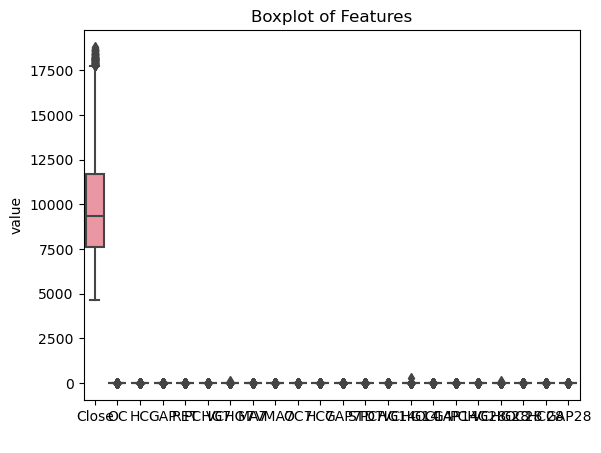

In [15]:
#study the distribution
# fig, ax = plt.subplots(figsize=(14,8))
sns.boxplot(x='variable', y='value', data=pd.melt(X))
plt.xlabel(' ')
plt.title('Boxplot of Features');

In [16]:
df1.loc[:, 'y'] = y
df1.head(3)

,Close,OC,HC,GAP,RET,PCHG7,VCHG7,RET7,MA7,VMA7,...,RET28,MA28,VMA28,OC28,HC28,GAP28,STD28,UB28,LB28,y
02/01/2012,4636.75,-0.000744,0.012620,0.001205,0.000501,0.003866,0.102204,0.003449,1.001524,1.002731,...,0.013517,1.006646,1.004614,-0.000663,0.011884,0.001208,0.009541,10517.850419,9687.522536,4765.30
03/01/2012,4765.30,0.019141,0.020809,0.008422,0.027347,0.003866,0.102204,0.003449,1.001524,1.002731,...,0.013517,1.006646,1.004614,-0.000663,0.011884,0.001208,0.009541,10517.850419,9687.522536,4749.65
04/01/2012,4749.65,-0.005298,0.011419,0.002025,-0.003290,0.003866,0.102204,0.003449,1.001524,1.002731,...,0.013517,1.006646,1.004614,-0.000663,0.011884,0.001208,0.009541,10517.850419,9687.522536,4749.95


In [17]:
# Specify y
df1['y'] = np.where(df1['Close'].shift(-1)>0.995*df1['Close'],1,0)

In [18]:
df1.head(2)

,Close,OC,HC,GAP,RET,PCHG7,VCHG7,RET7,MA7,VMA7,...,RET28,MA28,VMA28,OC28,HC28,GAP28,STD28,UB28,LB28,y
02/01/2012,4636.75,-0.000744,0.012620,0.001205,0.000501,0.003866,0.102204,0.003449,1.001524,1.002731,...,0.013517,1.006646,1.004614,-0.000663,0.011884,0.001208,0.009541,10517.850419,9687.522536,1
03/01/2012,4765.30,0.019141,0.020809,0.008422,0.027347,0.003866,0.102204,0.003449,1.001524,1.002731,...,0.013517,1.006646,1.004614,-0.000663,0.011884,0.001208,0.009541,10517.850419,9687.522536,1


In [19]:
# Check Class Imbalance
print(df1['y'].value_counts())

y
1    2071
0     647
Name: count, dtype: int64


In [20]:
print(df1.columns)

Index(['Close', 'OC', 'HC', 'GAP', 'RET', 'PCHG7', 'VCHG7', 'RET7', 'MA7',
       'VMA7', 'OC7', 'HC7', 'GAP7', 'STD7', 'UB7', 'LB7', 'PCHG14', 'VCHG14',
       'RET14', 'MA14', 'VMA14', 'OC14', 'HC14', 'GAP14', 'STD14', 'UB14',
       'LB14', 'PCHG28', 'VCHG28', 'RET28', 'MA28', 'VMA28', 'OC28', 'HC28',
       'GAP28', 'STD28', 'UB28', 'LB28', 'y'],
      dtype='object')


In [21]:
X = df1[['OC', 'HC', 'GAP', 'RET', 'PCHG7', 'VCHG7', 'RET7', 'MA7', 'VMA7',
       'OC7', 'HC7', 'GAP7', 'STD7', 'UB7', 'LB7', 'PCHG14', 'VCHG14', 'RET14',
       'MA14', 'VMA14', 'OC14', 'HC14', 'GAP14', 'STD14', 'UB14', 'LB14',
       'PCHG28', 'VCHG28', 'RET28', 'MA28', 'VMA28', 'OC28', 'HC28', 'GAP28',
       'STD28', 'UB28', 'LB28']]
y = df1['y']

In [22]:
# Create a SMOTE object
smote = SMOTE(random_state=42)

In [23]:
# Fit the SMOTE object to the data
X_resampled, y_resampled = smote.fit_resample(df1.drop('y', axis=1), df1['y'])

In [24]:
# Check the class imbalance after resampling
print(y_resampled.value_counts())

y
1    2071
0    2071
Name: count, dtype: int64


In [25]:
# Split the resampled data into training and test sets
X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [28]:
# Define a Baseline Model
classifier = Pipeline([
    ("scaler", StandardScaler()),
    ("classifier", SVC(kernel='linear', class_weight='balanced'))
])
# Train the model on the resampled training data
classifier.fit(X_train_resampled, y_train_resampled)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', SVC(class_weight='balanced', kernel='linear'))])

In [29]:
# Predict the Class Labels
y_pred = classifier.predict(X_test_resampled)

In [30]:
# Get the Scores
acc_train = accuracy_score(y_train_resampled, classifier.predict(X_train_resampled))
acc_test = accuracy_score(y_test_resampled, y_pred)
print(f'Baseline Model -- Train Accuracy: {acc_train:0.4}, Test Accuracy:{acc_test:0.4}')

Baseline Model -- Train Accuracy: 0.5841, Test Accuracy:0.5899


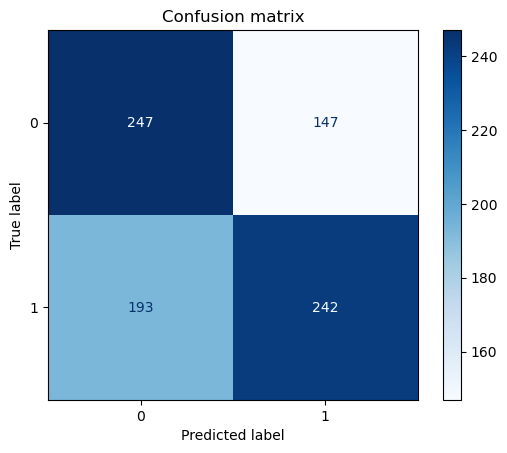

In [31]:
# Display confussion matrix
disp = ConfusionMatrixDisplay.from_estimator(
classifier,
X_test_resampled,
y_test_resampled,
# display_labels=model.classes_,
cmap=plt.cm.Blues
)
plt.title('Confusion matrix')
plt.show()

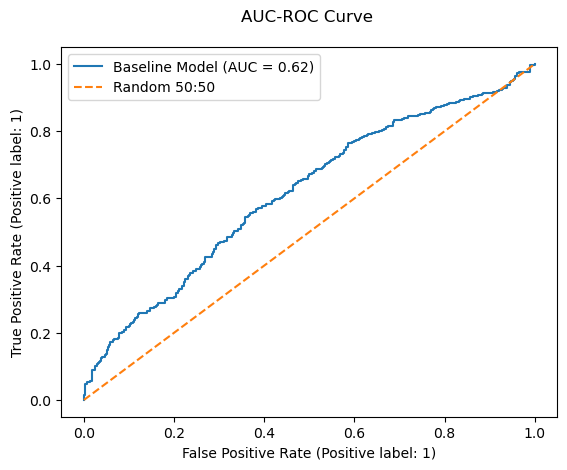

In [32]:
# Display ROCCurve
disp = RocCurveDisplay.from_estimator(
classifier,
X_test_resampled,
y_test_resampled,
name='Baseline Model')
plt.title("AUC-ROC Curve \n")
plt.plot([0,1],[0,1],linestyle="--", label='Random 50:50')
plt.legend()
plt.show()

In [33]:
 # Classification Report
print(classification_report(y_test_resampled, classifier.predict(X_test_resampled)))

              precision    recall  f1-score   support

           0       0.56      0.63      0.59       394
           1       0.62      0.56      0.59       435

    accuracy                           0.59       829
   macro avg       0.59      0.59      0.59       829
weighted avg       0.59      0.59      0.59       829



In [34]:
# defining parameter range 
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}  
  
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3) 
  
# fitting the model for grid search 
grid.fit(X_train_resampled, y_train_resampled)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.507 total time=   0.7s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.507 total time=   0.3s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.505 total time=   0.3s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.506 total time=   0.3s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.506 total time=   0.3s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.507 total time=   0.3s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.507 total time=   0.3s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.505 total time=   0.3s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.506 total time=   0.3s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.506 total time=   0.3s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.507 total time=   0.3s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)

In [35]:
# print best parameter after tuning 
print(grid.best_params_)

{'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}


In [36]:
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_)

SVC(C=10, gamma=0.0001)


In [37]:
print("Best Parameters:", grid.best_params_)
print("Best Score:", grid.best_score_)

Best Parameters: {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
Best Score: 0.7775482677384223


In [38]:
# re-run predictions and see a classification report on this grid object just like you would with a normal model
grid_predictions = grid.predict(X_train_resampled) 
  
# print classification report 
print(classification_report(y_train_resampled, grid_predictions, zero_division=0))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1677
           1       1.00      0.99      1.00      1636

    accuracy                           1.00      3313
   macro avg       1.00      1.00      1.00      3313
weighted avg       1.00      1.00      1.00      3313



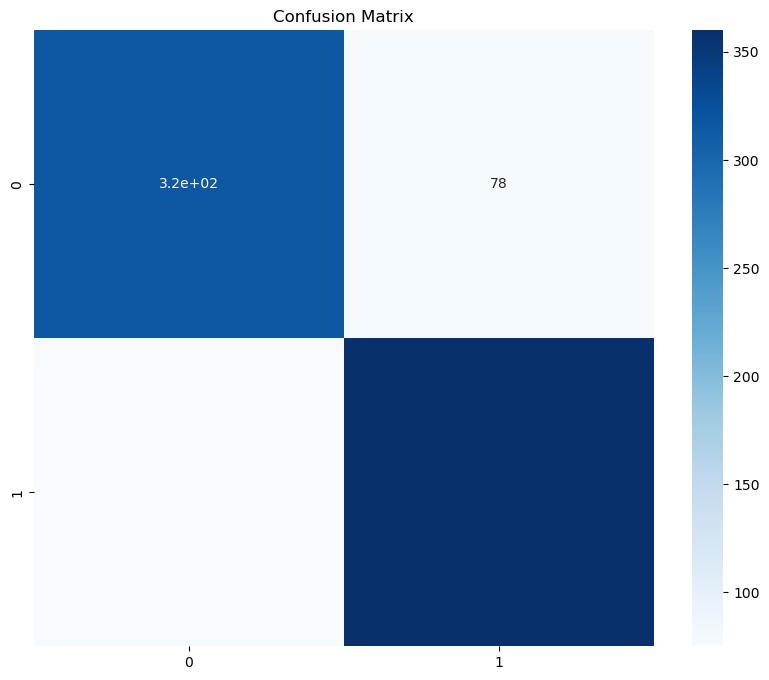

In [39]:
# Predicting the test set results
y_pred = grid.best_estimator_.predict(X_test_resampled)

# Confusion matrix
cnf_matrix = confusion_matrix(y_test_resampled, y_pred)

plt.figure(figsize=(10,8))
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

In [42]:
# Predict probabilities
y_pred = grid.best_estimator_.predict(X_test_resampled)
print(y_pred)

[1 1 0 0 1 1 1 1 0 0 1 1 0 0 1 1 0 1 1 0 0 1 1 1 0 1 1 0 1 1 1 1 0 1 1 1 0
 1 1 1 0 0 1 0 1 1 1 0 0 1 0 1 0 0 0 1 1 1 1 1 0 1 1 1 1 1 0 0 0 1 1 0 1 0
 0 1 0 1 0 1 1 0 1 0 0 1 1 1 0 1 1 0 0 1 1 1 0 0 0 0 0 1 0 0 1 0 0 0 0 1 1
 1 1 1 1 1 0 1 1 1 0 0 0 0 0 0 1 0 0 1 1 1 0 1 1 0 1 1 1 0 0 1 0 0 1 0 0 1
 0 1 0 0 1 0 1 1 0 0 0 0 1 0 1 1 0 1 1 1 1 1 1 1 1 0 0 0 1 0 1 1 1 1 1 1 1
 1 1 0 0 0 1 1 1 1 0 1 0 1 0 1 0 0 1 1 1 0 0 0 0 1 1 0 1 1 1 0 1 0 1 1 0 1
 0 1 1 0 1 1 0 0 0 0 0 1 0 0 0 0 1 0 1 1 1 0 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1
 0 1 0 1 0 1 0 1 1 1 0 1 0 0 0 1 1 0 1 0 0 1 1 0 0 0 1 0 1 0 1 0 1 0 0 1 0
 1 1 1 1 0 0 0 0 0 1 1 0 0 1 1 1 1 0 0 1 0 1 1 0 0 1 1 1 0 1 1 1 1 0 0 1 1
 1 1 1 0 1 0 0 0 0 0 1 0 0 0 1 1 0 0 0 1 1 0 1 1 1 0 1 1 0 1 0 0 0 1 0 1 0
 1 0 1 0 1 1 1 1 1 1 1 0 0 1 1 1 1 0 0 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 1 1 0
 1 0 1 0 0 1 0 1 0 0 1 0 1 0 1 1 1 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1
 0 0 1 1 0 1 0 1 1 1 0 1 0 0 1 1 1 1 1 0 1 0 0 1 0 0 0 1 0 0 0 1 1 0 1 1 1
 1 1 0 1 1 1 0 1 1 0 1 0 

In [44]:
# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_test_resampled, y_pred)

In [45]:
# Calculate AUC
auc_score = auc(fpr, tpr)

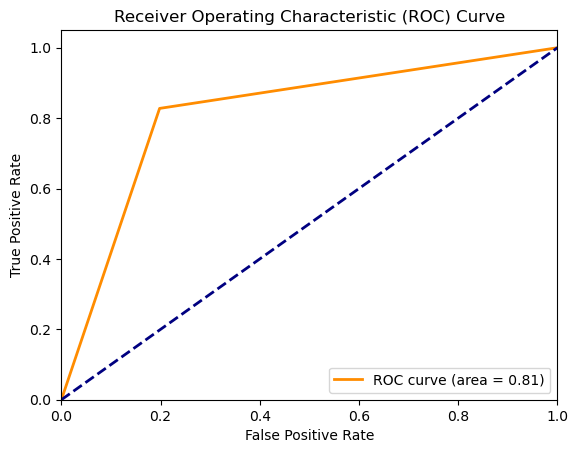

In [46]:
# Plot ROC curve

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

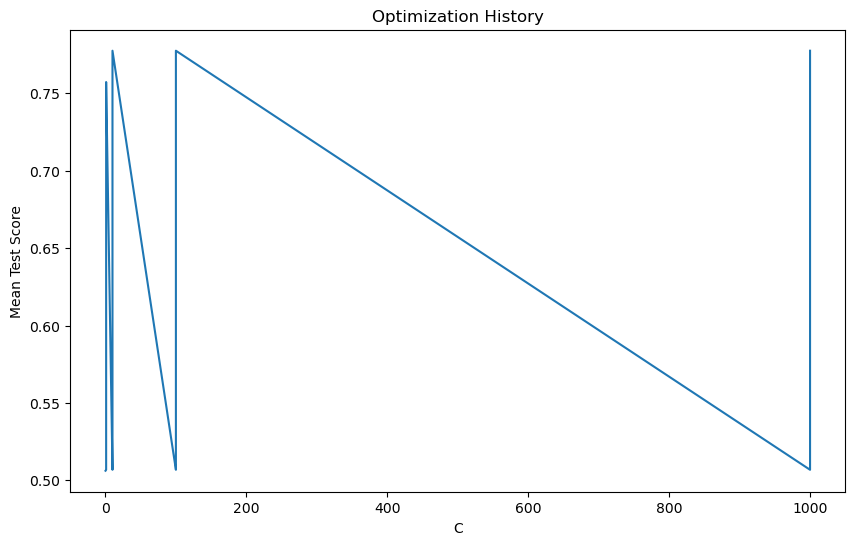

In [47]:
# Get the optimization history
param_grid = grid.cv_results_

# Plot the optimization history
plt.figure(figsize=(10,6))
plt.plot(param_grid['param_C'], param_grid['mean_test_score'])
plt.xlabel('C')
plt.ylabel('Mean Test Score')
plt.title('Optimization History')
plt.show()

In [55]:
# Calculate the permutation feature importance
importances = permutation_importance(grid.best_estimator_, X_test_resampled, y_test_resampled, n_repeats=10, random_state=42)

# Print the feature importances
print(importances)

{'importances_mean': array([2.81785283e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 2.82388420e-01, 2.82388420e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 2.82991556e-01, 2.81182147e-01, 0.00000000e+00,
       2.41254524e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.79613993e-01, 2.82750302e-01]), 'importances_std': array([0.00603619, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00449569,
       0.00601808, 0.        , 0.        , 0.        , 0.        ,
       0.   

TypeError: unhashable type: 'Bunch'

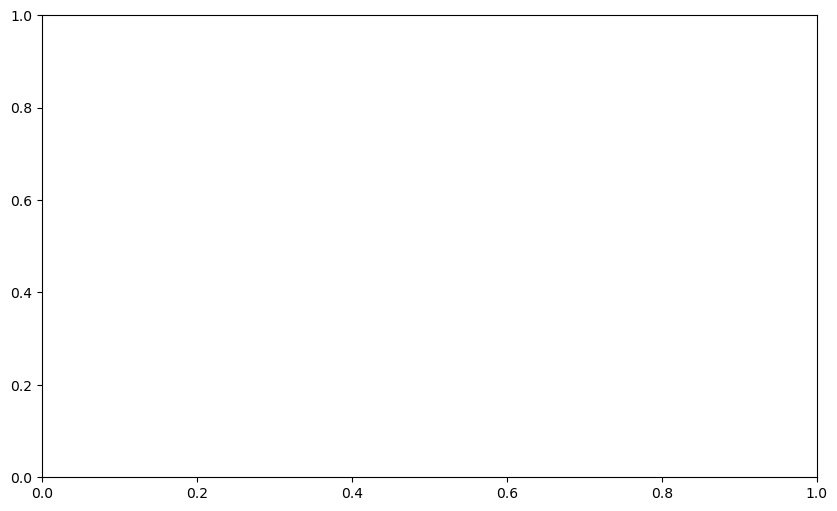

In [58]:
# Plot the feature importances
plt.figure(figsize=(10,6))
plt.bar(range(len(importances)), importances)
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.title('Permutation Feature Importances')
plt.show()